In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import os

In [2]:
MODEL_DIR="model"
DATA_DIR="data"
SPECTROGRAM_TRAIN_TFRECORD_FILENAME = "spectrogram_train.tfrecord"
SPECTROGRAM_VALID_TFRECORD_FILENAME = "spectrogram_valid.tfrecord"
SPECTROGRAM_TEST_TFRECORD_FILENAME = "spectrogram_test.tfrecord"

BUFFER_SIZE = 64
BATCH_SIZE = 16
SPECTROGRAM_SHAPE = (85, 129)

# Preparation

In [3]:
model = tf.keras.models.load_model('model')

In [18]:
test_dataset = tf.data.TFRecordDataset([os.path.join(DATA_DIR, SPECTROGRAM_TEST_TFRECORD_FILENAME)])

In [5]:
feature_description = {
    'spectrogram': tf.io.FixedLenFeature([], tf.string, default_value=''),
    'label': tf.io.FixedLenFeature([], tf.float32, default_value=0.0)
}

def _parse_function(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_description)
    spectrogram = tf.io.parse_tensor(example['spectrogram'], out_type=tf.float32)
    spectrogram = tf.ensure_shape(spectrogram, SPECTROGRAM_SHAPE)
    label = tf.ensure_shape(example['label'], ())
    return spectrogram, label

In [19]:
test_dataset = test_dataset.map(_parse_function)

In [20]:
testing_dataset = test_dataset.batch(BATCH_SIZE).prefetch(BUFFER_SIZE).cache()

# Run the model on CPU

In [21]:
model.evaluate(testing_dataset)

93/93 [==============================] - 23s 243ms/step - loss: 0.0278 - accuracy: 0.9906


[0.02776455320417881, 0.9905533194541931]

Since 1 batch contains 4 seconds of data, this is sufficient.

# Precision Recall analysis

In [28]:
y_pred = np.argmax(model.predict(testing_dataset), axis=1)

In [22]:
y = np.array([label for spectrogram, label in test_dataset.as_numpy_iterator()])

In [31]:
m = tf.keras.metrics.Precision()
m.update_state(y, y_pred)
m.result().numpy()

0.9933775

In [32]:
m = tf.keras.metrics.Recall()
m.update_state(y, y_pred)
m.result().numpy()

0.96153843

The model achieves sufficiently high precision and recall on the test set.

# Test on actual audio

Taken from here: https://www.youtube.com/watch?v=mxnL7UrkmY4 

Note that this audio is noisier than the training data. It contains extra factors including narration and speech. These factors were not accounted for in the training data because the algorithm's purpose is not to classify applauses from other noise.

In [9]:
rach, rach_sampling_rate = tf.audio.decode_wav(tf.io.read_file(os.path.join(DATA_DIR, 'rachmaninoff.wav')))

In [10]:
rach_sampling_rate

<tf.Tensor: shape=(), dtype=int32, numpy=48000>

Since the sampling rate is different from our training set, we need to make the splits shorter. (The split lengths can't be changed from 11025 for STFT.)

In [11]:
def split_data(d, d_sampling_rate):
    data_size = d.shape[0]
    batch_size = 44100 // 4
    batch_count = data_size // batch_size 
    return np.array_split(d[:batch_count * batch_size], batch_count)

In [12]:
rach_split = split_data(rach, rach_sampling_rate)
DATA_SIZE = len(rach_split)

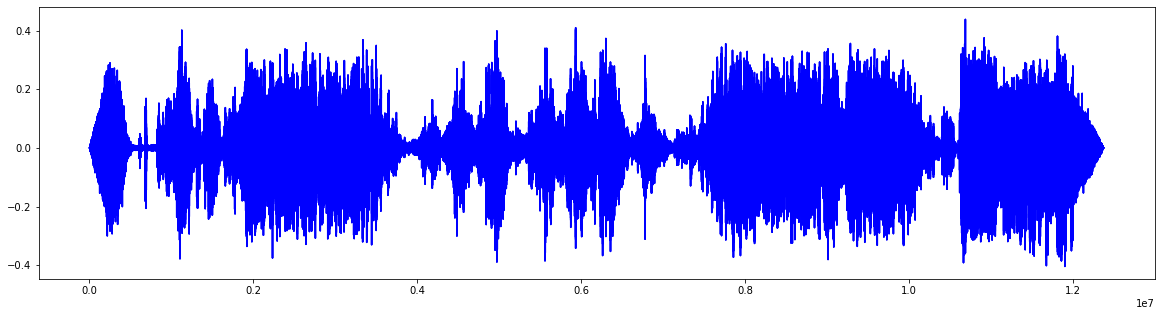

In [13]:
fig = plt.figure(figsize=(20, 5))
plt.plot(rach, color='blue')

In [36]:
dataset = tf.data.Dataset.from_tensor_slices(rach_split)

In [37]:
def get_spectrogram(waveform):
    spectrogram1 = tf.signal.stft(waveform[:, 0], frame_length=256, frame_step=128)
    spectrogram1 = tf.abs(spectrogram1)
    return spectrogram1

In [38]:
dataset = dataset.map(get_spectrogram)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [39]:
dataset = dataset.batch(BATCH_SIZE).prefetch(BUFFER_SIZE).cache()

In [49]:
y_pred = model.predict(dataset)

In [50]:
y_pred = np.argmax(y_pred, axis=1)

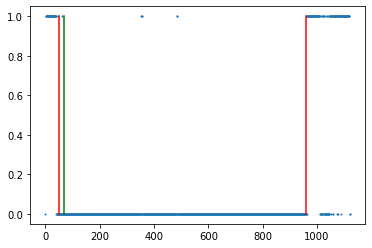

In [55]:
plt.scatter(np.arange(y_pred.shape[0]), y_pred, s=1)
plt.plot(np.linspace(51, 51), np.linspace(0, 1), c='red')
plt.plot(np.linspace(70, 70), np.linspace(0, 1), c='green')
plt.plot(np.linspace(960, 960), np.linspace(0, 1), c='red')

The video contains applauses roughly from 0:00-0:11 (0-51) and 3:41-4:17 (960-1122), and music from 0:16-3:40 (70-959). (Boundaries plotted above) 

It looks like the model predicts the labels quite conservatively, where precision seems to be very high (from inspection) but recall is not. This might be because in the applauses at the end also involve speech from the narrator. Also note that the time sections which are neither applauses or music (the performer is speaking/waiting and the audience is quiet) is classified negatively.

# Sequential cleanup


We would like to incorporate sequential data, as much as the circumstances allow. The algorithm would likely have a harder time deciphering the boundary points if the data flows one way (i.e. in an RNN). Instead, we will try a simpler algorithm - if a single time section of one label is bounded on both sides by a time sections of a different label, and either one of the bounding time sections is consecutively connected, the former time section is to be converted. 

As an example:

1 0 1 1 -> 1 1 1 1
0 1 0 1 -> 0 1 0 1
1 1 0 1 0 1 0 0 -> 1 1 1 1 0 0 0 0

In [52]:
def transform(s):
    t = np.zeros(s.shape)
    t[0] = s[0]
    for i in range(1, s.shape[0] - 1):
        if s[i - 1] != s[i] and s[i + 1] != s[i]:
            if (i - 2 >= 0 and s[i - 2] != s[i]) or (i + 2 < s.shape[0] and s[i + 2] != s[i]):
                t[i] = s[i - 1]
            else:
                t[i] = s[i]
        else:
            t[i] = s[i]
    t[s.shape[0] - 1] = s[s.shape[0] - 1]
    return t

In [53]:
y_trans = transform(y_pred)

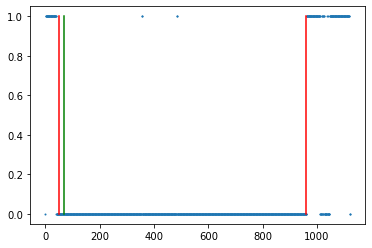

In [54]:
plt.scatter(np.arange(y_trans.shape[0]), y_trans, s=1)
plt.plot(np.linspace(51, 51), np.linspace(0, 1), c='red')
plt.plot(np.linspace(70, 70), np.linspace(0, 1), c='green')
plt.plot(np.linspace(960, 960), np.linspace(0, 1), c='red')

In [57]:
for i in range(300, 500):
    if y_pred[i] == 1:
        print(i)

351
355
356
484
485


Notice that this process cannot be satisfied with a trivial algorithm. Due to the nature of imperfectness of models, it seems difficult to achieve perfection. 

The incorporation of sequential data will be a topic for another study. We predict that it will be a similar task to video segment classification using an RNN.